In [ ]:
Simport pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
dir = "./"

# Exploratory Data Analysis

In [ ]:
print('Reading the data....', end='')
application = pd.read_csv(dir + 'application_train.csv')
print('done!!!')
print('The shape of data:',application.shape)
print('First 5 rows of data:')
application.head()

Reading the data....done!!!
The shape of data: (27166, 122)
First 5 rows of data:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


**Let's check for missing values in each column**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
count = application.isnull().sum().sort_values(ascending=False)
percentage = ((application.isnull().sum()/len(application)*100)).sort_values(ascending=False)
missing_application = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
print('Count and percentage of missing values for top 20 columns:')
missing_application.head(20)

Count and percentage of missing values for top 20 columns:


,Count,Percentage
COMMONAREA_MEDI,19027,70.039756
COMMONAREA_AVG,19027,70.039756
COMMONAREA_MODE,19027,70.039756
NONLIVINGAPARTMENTS_AVG,18873,69.472870
NONLIVINGAPARTMENTS_MEDI,18873,69.472870
NONLIVINGAPARTMENTS_MODE,18873,69.472870
LIVINGAPARTMENTS_MODE,18601,68.471619
LIVINGAPARTMENTS_AVG,18601,68.471619
LIVINGAPARTMENTS_MEDI,18601,68.471619
FONDKAPREMONT_MODE,18599,68.464257


**Let’s check for duplicate data**

In [ ]:
columns_without_id = [col for col in application.columns if col!='SK_ID_CURR']
#Checking for duplicates in the data.
application[application.duplicated(subset = columns_without_id, keep=False)]
print('The no of duplicates in the data:',application[application.duplicated(subset = columns_without_id, keep=False)]
      .shape[0])

The no of duplicates in the data: 0


**Let’s check the distribution of data points among output class.**

In [ ]:
cf.set_config_file(theme='polar')
target_val = application['TARGET'].value_counts()
target_df = pd.DataFrame({'labels': ["Loan Repayed (0)", "Loan not Repayed(1)"],
                   'values': target_val.values
                  })
target_df.iplot(kind='pie',labels='labels',values='values', title='Loan Repayed or not', hole = 0.6)

The data is imbalanced (91.9%(Loan repayed-0) and 8.07%(Loan not repayed-1)) and we need to handle this problem.

**Distribution of AMT_INCOME_TOTAL.**

In [ ]:
application[application['AMT_INCOME_TOTAL'] < 2000000]['AMT_INCOME_TOTAL'].iplot(kind='histogram', bins=100,
   xTitle = 'Total Income', yTitle ='Count of applicants',
             title='Distribution of AMT_INCOME_TOTAL')

In [ ]:
(application[application['AMT_INCOME_TOTAL'] > 1000000]['TARGET'].value_counts())/len(application[application['AMT_INCOME_TOTAL'] > 1000000])*100

TARGET
0    95.652174
1     4.347826
Name: count, dtype: float64

**Types of loan available.**

In [ ]:
cf.set_config_file(theme='polar')
contract_val = application['NAME_CONTRACT_TYPE'].value_counts()
contract_df = pd.DataFrame({'labels': contract_val.index,
                   'values': contract_val.values
                  })
contract_df.iplot(kind='pie',labels='labels',values='values', title='Types of Loan', hole = 0.6)

**Distribution of AMT_CREDIT**

In [ ]:
application['AMT_CREDIT'].iplot(kind='histogram', bins=100,
            xTitle = 'Credit Amount',yTitle ='Count of applicants',
            title='Distribution of AMT_CREDIT')

In [ ]:
np.log(application['AMT_CREDIT']).iplot(kind='histogram', bins=100,
        xTitle = 'log(Credit Amount)',yTitle ='Count of applicants',
        title='Distribution of log(AMT_CREDIT)')

In [ ]:
cf.set_config_file(theme='polar')
suite_val = (application['NAME_TYPE_SUITE'].value_counts()/len(application))*100
suite_val.iplot(kind='bar', xTitle = 'Name of type of the Suite',
             yTitle='Count of applicants in %',
             title='Who accompanied client when applying for the  application in % ')

In [ ]:
suite_val = application['NAME_TYPE_SUITE'].value_counts()
suite_val_y0 = []
suite_val_y1 = []
for val in suite_val.index:
    suite_val_y1.append(np.sum(application['TARGET'][application['NAME_TYPE_SUITE']==val] == 1))
    suite_val_y0.append(np.sum(application['TARGET'][application['NAME_TYPE_SUITE']==val] == 0))
data = [go.Bar(x = suite_val.index, y = ((suite_val_y1 / suite_val.sum()) * 100), name='Yes' ),
        go.Bar(x = suite_val.index, y = ((suite_val_y0 / suite_val.sum()) * 100), name='No' )]
layout = go.Layout(
    title = "Who accompanied client when applying for the  application in terms of loan is repayed or not in %",
    xaxis=dict(
        title='Name of type of the Suite',
       ),
    yaxis=dict(
        title='Count of applicants in %',
        )
)
fig = go.Figure(data = data, layout=layout)
fig.layout.template = 'plotly_dark'
py.iplot(fig)

In [ ]:
income_val = application['NAME_INCOME_TYPE'].value_counts()
income_val_y0 = []
income_val_y1 = []
for val in income_val.index:
    income_val_y1.append(np.sum(application['TARGET'][application['NAME_INCOME_TYPE']==val] == 1))
    income_val_y0.append(np.sum(application['TARGET'][application['NAME_INCOME_TYPE']==val] == 0))
data = [go.Bar(x = income_val.index, y = ((income_val_y1 / income_val.sum()) * 100), name='Yes' ),
        go.Bar(x = income_val.index, y = ((income_val_y0 / income_val.sum()) * 100), name='No' )]
layout = go.Layout(
    title = "Income sources of Applicants in terms of loan is repayed or not  in %",
    xaxis=dict(
        title='Income source',
       ),
    yaxis=dict(
        title='Count of applicants in %',
        )
)
fig = go.Figure(data = data, layout=layout)
fig.layout.template = 'plotly_dark'
py.iplot(fig)

**Distribution of Education of Applicants in terms of loan is repayed or not.**

In [ ]:
education_val = application['NAME_EDUCATION_TYPE'].value_counts()
education_val_y0 = []
education_val_y1 = []
for val in education_val.index:
    education_val_y1.append(np.sum(application['TARGET'][application['NAME_EDUCATION_TYPE']==val] == 1))
    education_val_y0.append(np.sum(application['TARGET'][application['NAME_EDUCATION_TYPE']==val] == 0))
data = [go.Bar(x = education_val.index, y = ((education_val_y1 / education_val.sum()) * 100), name='Yes' ),
        go.Bar(x = education_val.index, y = ((education_val_y0 / education_val.sum()) * 100), name='No' )]
layout = go.Layout(
    title = "Education sources of Applicants in terms of loan is repayed or not  in %",
    xaxis=dict(
        title='Education of Applicants',
       ),
    yaxis=dict(
        title='Count of applicants in %',
        )
)
fig = go.Figure(data = data, layout=layout)
fig.layout.template = 'plotly_dark'
py.iplot(fig)

**Distribution of Clients Age**

In [ ]:
cf.set_config_file(theme='pearl')
(application['DAYS_BIRTH']/(-365)).iplot(kind='histogram',
             xTitle = 'Age', bins=50,
             yTitle='Count of type of applicants in %',
             title='Distribution of Clients Age')

**Distribution of years before the application the person started current employment.**

In [ ]:
cf.set_config_file(theme='pearl')
(application['DAYS_EMPLOYED']).iplot(kind='histogram',
             xTitle = 'Days',bins=50,
             yTitle='Count of applicants in %',
             title='Days before the application the person started current employment')

In [ ]:
# Create an error flag column
application['DAYS_EMPLOYED_ERROR'] = application["DAYS_EMPLOYED"] == 365243
# Replace the error values with nan
application['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [ ]:
# Flag to represent when Total income is greater than Credit
application['INCOME_GT_CREDIT_FLAG'] = application['AMT_INCOME_TOTAL'] > application['AMT_CREDIT']
# Column to represent Credit Income Percent
application['CREDIT_INCOME_PERCENT'] = application['AMT_CREDIT'] / application['AMT_INCOME_TOTAL']
# Column to represent Annuity Income percent
application['ANNUITY_INCOME_PERCENT'] = application['AMT_ANNUITY'] / application['AMT_INCOME_TOTAL']
# Column to represent Credit Term
application['CREDIT_TERM'] = application['AMT_CREDIT'] / application['AMT_ANNUITY']
# Column to represent Days Employed percent in his life
application['DAYS_EMPLOYED_PERCENT'] = application['DAYS_EMPLOYED'] / application['DAYS_BIRTH']
# Shape of Application data
print("The shape of application data:",application.shape)

The shape of application data: (27166, 128)


In [ ]:
print('Reading the data....', end='')
bureau = pd.read_csv(dir+'bureau.csv')
print('done!!!')
print('The shape of data:',bureau.shape)
print('First 5 rows of data:')
bureau.head()

Reading the data....done!!!
The shape of data: (148547, 17)
First 5 rows of data:


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
bureau.columns.size
127+17

144

In [ ]:
# Combining numerical features
grp = bureau.select_dtypes(include=['float64', 'int64']).drop(['SK_ID_BUREAU'], axis = 1).groupby(by=['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
application_bureau = application.merge(grp, on='SK_ID_CURR', how='left')
application_bureau.update(application_bureau[grp.columns].fillna(0))
application_bureau.columns.size

140

In [ ]:
# Combining categorical features
bureau_categorical = pd.get_dummies(bureau.select_dtypes('object'))
bureau_categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
grp = bureau_categorical.groupby(by = ['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau.update(application_bureau[grp.columns].fillna(0))
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked),BUREAU_CREDIT_TYPE_Consumer credit,BUREAU_CREDIT_TYPE_Credit card,BUREAU_CREDIT_TYPE_Loan for business development,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('The shape application and bureau data combined:',application_bureau.shape)

The shape application and bureau data combined: (27166, 160)


In [ ]:
# Number of past loans per customer
grp = bureau.groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count().reset_index().rename(columns = {'SK_ID_BUREAU': 'BUREAU_LOAN_COUNT'})
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_CREDIT_TYPE_Consumer credit,BUREAU_CREDIT_TYPE_Credit card,BUREAU_CREDIT_TYPE_Loan for business development,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan,BUREAU_LOAN_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
application_bureau['BUREAU_LOAN_COUNT'] = application_bureau['BUREAU_LOAN_COUNT'].fillna(0)
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_CREDIT_TYPE_Consumer credit,BUREAU_CREDIT_TYPE_Credit card,BUREAU_CREDIT_TYPE_Loan for business development,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan,BUREAU_LOAN_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Number of types of past loans per customer
grp = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')

In [ ]:
application_bureau['BUREAU_LOAN_TYPES'] = application_bureau['BUREAU_LOAN_TYPES'].fillna(0)
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_CREDIT_TYPE_Credit card,BUREAU_CREDIT_TYPE_Loan for business development,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan,BUREAU_LOAN_COUNT,BUREAU_LOAN_TYPES
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM': 'TOTAL_CREDIT_SUM'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CREDIT_SUM_DEBT'})
grp1['DEBT_CREDIT_RATIO'] = grp2['TOTAL_CREDIT_SUM_DEBT']/grp1['TOTAL_CREDIT_SUM']
del grp1['TOTAL_CREDIT_SUM']
application_bureau = application_bureau.merge(grp1, on='SK_ID_CURR', how='left')

In [ ]:
application_bureau['DEBT_CREDIT_RATIO']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
27161         NaN
27162         NaN
27163         NaN
27164    0.779129
27165         NaN
Name: DEBT_CREDIT_RATIO, Length: 27166, dtype: float64

In [ ]:
application_bureau['DEBT_CREDIT_RATIO'] = application_bureau['DEBT_CREDIT_RATIO'].fillna(0)
application_bureau['DEBT_CREDIT_RATIO'] = application_bureau['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], 0)
application_bureau['DEBT_CREDIT_RATIO'] = pd.to_numeric(application_bureau['DEBT_CREDIT_RATIO'], downcast='float')
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_CREDIT_TYPE_Loan for business development,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan,BUREAU_LOAN_COUNT,BUREAU_LOAN_TYPES,DEBT_CREDIT_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Overdue over debt ratio
bureau['AMT_CREDIT_SUM_OVERDUE'] = bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT'})
grp1['OVERDUE_DEBT_RATIO'] = grp1['TOTAL_CUSTOMER_OVERDUE']/grp2['TOTAL_CUSTOMER_DEBT']
del grp1['TOTAL_CUSTOMER_OVERDUE']
application_bureau = application_bureau.merge(grp1, on='SK_ID_CURR', how='left')

In [ ]:
application_bureau['OVERDUE_DEBT_RATIO']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
27161    NaN
27162    NaN
27163    NaN
27164    0.0
27165    NaN
Name: OVERDUE_DEBT_RATIO, Length: 27166, dtype: float64

In [ ]:
application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau['OVERDUE_DEBT_RATIO'].fillna(0)
application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau['OVERDUE_DEBT_RATIO'].replace([np.inf, -np.inf], 0)
application_bureau['OVERDUE_DEBT_RATIO'] = pd.to_numeric(application_bureau['OVERDUE_DEBT_RATIO'], downcast='float')
application_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment,BUREAU_CREDIT_TYPE_Loan for working capital replenishment,BUREAU_CREDIT_TYPE_Microloan,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Real estate loan,BUREAU_CREDIT_TYPE_Unknown type of loan,BUREAU_LOAN_COUNT,BUREAU_LOAN_TYPES,DEBT_CREDIT_RATIO,OVERDUE_DEBT_RATIO
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Reading the data....', end='')
previous_applicaton = pd.read_csv(dir+'previous_application.csv')
print('done!!!')
print('The shape of data:',previous_applicaton.shape)
print('First 5 rows of data:')
previous_applicaton.head()

Reading the data....done!!!
The shape of data: (55461, 37)
First 5 rows of data:


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Number of previous applications per customer
grp = previous_applicaton[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'})
application_bureau_prev = application_bureau.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev['PREV_APP_COUNT'] = application_bureau_prev['PREV_APP_COUNT'].fillna(0)

In [ ]:
# Combining numerical features
grp = previous_applicaton.select_dtypes(include=['float64', 'int64']).drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [ ]:
# Combining categorical features
prev_categorical = pd.get_dummies(previous_applicaton.select_dtypes('object'))
prev_categorical['SK_ID_CURR'] = previous_applicaton['SK_ID_CURR']
prev_categorical.head()
grp = prev_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [ ]:
print('Reading the data....', end='')
pos_cash = pd.read_csv(dir + 'POS_CASH_balance.csv')
print('done!!!')
print('The shape of data:',pos_cash.shape)
print('First 5 rows of data:')
pos_cash.head()

Reading the data....done!!!
The shape of data: (346985, 8)
First 5 rows of data:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943.0,-31.0,48.0,45.0,Active,0.0,0.0
1,1715348,367990.0,-33.0,36.0,35.0,Active,0.0,0.0
2,1784872,397406.0,-32.0,12.0,9.0,Active,0.0,0.0
3,1903291,269225.0,-35.0,48.0,42.0,Active,0.0,0.0
4,2341044,334279.0,-35.0,36.0,35.0,Active,0.0,0.0


In [ ]:
# Combining numerical features
grp = pos_cash.select_dtypes(include=['float64', 'int64']).drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [ ]:
# Combining categorical features
pos_cash_categorical = pd.get_dummies(pos_cash.select_dtypes('object'))
pos_cash_categorical['SK_ID_CURR'] = pos_cash['SK_ID_CURR']
grp = pos_cash_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [ ]:
print('Reading the data....', end='')
insta_payments = pd.read_csv(dir + 'installments_payments.csv')
print('done!!!')
print('The shape of data:',insta_payments.shape)
print('First 5 rows of data:')
insta_payments.head()

Reading the data....done!!!
The shape of data: (256489, 8)
First 5 rows of data:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6.0,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34.0,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1.0,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3.0,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2.0,-1383.0,-1366.0,2165.040,2160.585


In [ ]:
insta_payments.dtypes

SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     float64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

In [ ]:
# Combining numerical features and there are no categorical features in this dataset
grp = insta_payments.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['INSTA_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')

In [ ]:
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [ ]:
print('Reading the data....', end='')
credit_card = pd.read_csv(dir + 'credit_card_balance.csv')
print('done!!!')
print('The shape of data:',credit_card.shape)
print('First 5 rows of data:')
credit_card.head()

Reading the data....done!!!
The shape of data: (125323, 23)
First 5 rows of data:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0.0,0.0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0.0,0.0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0.0,0.0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0.0,0.0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0.0,0.0


In [ ]:
# Combining numerical features
grp = credit_card.select_dtypes(include=['float64', 'int64']).drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [ ]:
# Combining categorical features
credit_categorical = pd.get_dummies(credit_card.select_dtypes('object'))
credit_categorical['SK_ID_CURR'] = credit_card['SK_ID_CURR']
grp = credit_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [ ]:
y = application_bureau_prev.pop('TARGET').values
X_train, X_temp, y_train, y_temp = train_test_split(application_bureau_prev.drop(['SK_ID_CURR'],axis=1), y, stratify = y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)
print('Shape of X_train:',X_train.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of X_test:',X_test.shape)

Shape of X_train: (19016, 365)
Shape of X_val: (4075, 365)
Shape of X_test: (4075, 365)


In [ ]:
print(sklearn.__version__)

1.2.2


In [ ]:
# Seperation of columns into numeric and categorical columns
types = np.array([dt for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]
# Featurization of numeric data
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
X_val_num = imputer_num.transform(X_val[num_cols])
X_test_num = imputer_num.transform(X_test[num_cols])
scaler_num = StandardScaler()
X_train_num1 = scaler_num.fit_transform(X_train_num)
X_val_num1 = scaler_num.transform(X_val_num)
X_test_num1 = scaler_num.transform(X_test_num)
X_train_num_final = pd.DataFrame(X_train_num1, columns=num_cols)
X_val_num_final = pd.DataFrame(X_val_num1, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num1, columns=num_cols)
# Featurization of categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
X_val_cat = imputer_cat.transform(X_val[cat_cols])
X_test_cat = imputer_cat.transform(X_test[cat_cols])
X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat2 = ohe.fit_transform(X_train_cat1)
X_val_cat2 = ohe.transform(X_val_cat1)
X_test_cat2 = ohe.transform(X_test_cat1)
cat_cols_ohe = list(ohe.get_feature_names_out(input_features=cat_cols))

In [ ]:
X_train_cat_final = pd.DataFrame.sparse.from_spmatrix(X_train_cat2)
X_train_cat_final.columns =  cat_cols_ohe
X_val_cat_final = pd.DataFrame.sparse.from_spmatrix(X_val_cat2)
X_val_cat_final.columns =  cat_cols_ohe
X_test_cat_final = pd.DataFrame.sparse.from_spmatrix(X_test_cat2)
X_test_cat_final.columns =  cat_cols_ohe
# # Final complete data
X_train_final = pd.concat([X_train_num_final,X_train_cat_final], axis = 1)
X_val_final = pd.concat([X_val_num_final,X_val_cat_final], axis = 1)
X_test_final = pd.concat([X_test_num_final,X_test_cat_final], axis = 1)
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

(19016, 491)
(4075, 491)
(4075, 491)


In [ ]:
import re
X_train_final = X_train_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val_final = X_val_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_final = X_test_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
# Saving the Dataframes into CSV files for future use
X_train_final.to_csv('X_train_final.csv')
X_val_final.to_csv('X_val_final.csv')
X_test_final.to_csv('X_test_final.csv')
# Saving the numpy arrays into text files for future use
np.savetxt('y.txt', y)
np.savetxt('y_train.txt', y_train)
np.savetxt('y_val.txt', y_val)
np.savetxt('y_test.txt', y_test)

In [ ]:
model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000,
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features, valid_features, train_y, valid_y = train_test_split(X_train_final, y_train, test_size = 0.15, random_state = 42)
model_sk.fit(train_features, train_y, eval_set = [(valid_features, valid_y)], eval_metric = 'auc')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1294, number of negative: 14869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21168
[LightGBM] [Info] Number of data points in the train set: 16163, number of used features: 380
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positiv

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.01, max_depth=7, n_estimators=2000, n_jobs=-1,
               subsample=0.9)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_sk.feature_importances_, X_train_final.columns)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df['Value']>=50]['Feature'])
# Saving the selected features into pickle file
with open('select_features.txt','wb') as fp:
    pickle.dump(selected_features, fp)
print('The no. of features selected:',len(selected_features))

The no. of features selected: 164


In [ ]:
# Feature importance Plot
data1 = features_df.head(20)
data = [go.Bar(x =data1.sort_values(by='Value')['Value'] , y = data1.sort_values(by='Value')['Feature'], orientation = 'h',
              marker = dict(
        color = 'rgba(43, 13, 150, 0.6)',
        line = dict(
            color = 'rgba(43, 13, 150, 1.0)',
            width = 1.5)
    )) ]
layout = go.Layout(
    autosize=False,
    width=1300,
    height=700,
    title = "Top 20 important features",
    xaxis=dict(
        title='Importance value'
        ),
    yaxis=dict(
        automargin=True
        ),
    bargap=0.4
    )
fig = go.Figure(data = data, layout=layout)
fig.layout.template = 'seaborn'
py.iplot(fig)

In [ ]:
def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)

    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)

    # Precision matrix
    B = (C/C.sum(axis=0))

    plt.figure(figsize=(20,4))

    labels = ['Re-paid(0)','Not Re-paid(1)']
    cmap=sns.light_palette("purple")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Confusion matrix')

    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Recall matrix')

    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Precision matrix')

    plt.show()
def cv_plot(alpha, cv_auc):

    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

For alpha 0.0001, cross validation AUC score 0.6952348082075986
For alpha 0.001, cross validation AUC score 0.7306657332432547
For alpha 0.01, cross validation AUC score 0.7349265173841951
For alpha 0.1, cross validation AUC score 0.7064354811862964
For alpha 1.0, cross validation AUC score 0.5
For alpha 10.0, cross validation AUC score 0.5
For alpha 100.0, cross validation AUC score 0.5
For alpha 1000.0, cross validation AUC score 0.5
For alpha 10000.0, cross validation AUC score 0.5


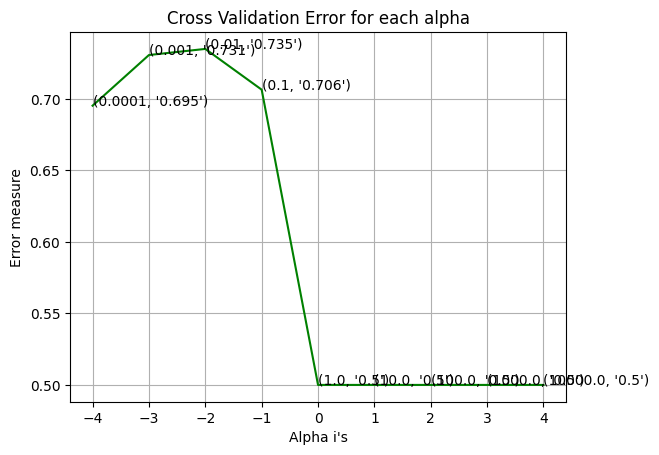

The Optimal C value is: 0.01


In [ ]:
alpha = np.logspace(-4,4,9)
cv_auc_score = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1',class_weight = 'balanced', loss='log', random_state=28)
    clf.fit(X_train_final[selected_features], y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train_final[selected_features], y_train)
    y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features])[:,1]
    cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
    print('For alpha {0}, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
cv_plot(alpha, cv_auc_score)
print('The Optimal C value is:', alpha[np.argmax(cv_auc_score)])

For best alpha 0.01, The Train AUC score is 0.7453645079289059
For best alpha 0.01, The Cross validated AUC score is 0.7349265173841951
For best alpha 0.01, The Test AUC score is 0.729908343656468
The test AUC score is : 0.729908343656468
The percentage of misclassified points 31.07% :


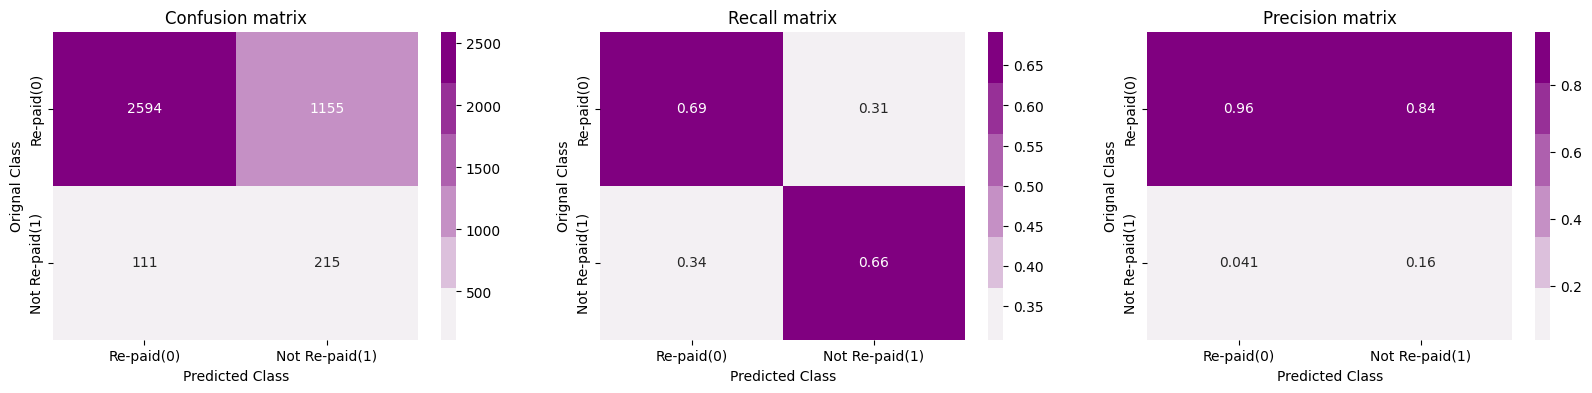

In [ ]:
best_alpha = alpha[np.argmax(cv_auc_score)]
logreg = SGDClassifier(alpha = best_alpha, class_weight = 'balanced', penalty = 'l1', loss='log', random_state = 28)
logreg.fit(X_train_final[selected_features], y_train)
logreg_sig_clf = CalibratedClassifierCV(logreg, method='sigmoid')
logreg_sig_clf.fit(X_train_final[selected_features], y_train)
y_pred_prob = logreg_sig_clf.predict_proba(X_train_final[selected_features])[:,1]
print('For best alpha {0}, The Train AUC score is {1}'.format(best_alpha, roc_auc_score(y_train,y_pred_prob) ))
y_pred_prob = logreg_sig_clf.predict_proba(X_val_final[selected_features])[:,1]
print('For best alpha {0}, The Cross validated AUC score is {1}'.format(best_alpha, roc_auc_score(y_val,y_pred_prob) ))
y_pred_prob = logreg_sig_clf.predict_proba(X_test_final[selected_features])[:,1]
print('For best alpha {0}, The Test AUC score is {1}'.format(best_alpha, roc_auc_score(y_test,y_pred_prob) ))
y_pred = logreg.predict(X_test_final[selected_features])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

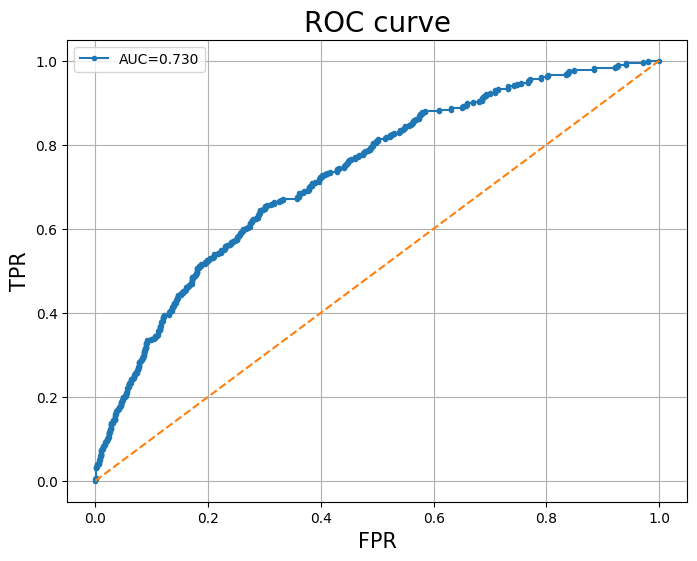

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [ ]:
alpha = [200,500,1000,2000]
max_depth = [7, 10]
cv_auc_score = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j,class_weight='balanced',
                                     random_state=42, n_jobs=-1)
        clf.fit(X_train_final[selected_features], y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_final[selected_features], y_train)
        y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features])[:,1]
        cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
        print('For n_estimators {0}, max_depth {1} cross validation AUC score {2}'.
              format(i,j,roc_auc_score(y_val,y_pred_prob)))

For n_estimators 200, max_depth 7 cross validation AUC score 0.7358681000917104
For n_estimators 200, max_depth 10 cross validation AUC score 0.7321327745847734
For n_estimators 500, max_depth 7 cross validation AUC score 0.7355825247471434
For n_estimators 500, max_depth 10 cross validation AUC score 0.7311128626398912
For n_estimators 1000, max_depth 7 cross validation AUC score 0.7371858263244984
For n_estimators 1000, max_depth 10 cross validation AUC score 0.7318806523519985
For n_estimators 2000, max_depth 7 cross validation AUC score 0.7377471858589617
For n_estimators 2000, max_depth 10 cross validation AUC score 0.7318733089859953


The optimal values are: n_estimators 2000, max_depth 7 
For best n_estimators 2000 best max_depth 7, The Train AUC score is 0.8676786048815385
For best n_estimators 2000 best max_depth 7, The Validation AUC score is 0.7377471858589617
For best n_estimators 2000 best max_depth 7, The Test AUC score is 0.7191480100214862
The test AUC score is : 0.7191480100214862
The percentage of misclassified points 08.00% :


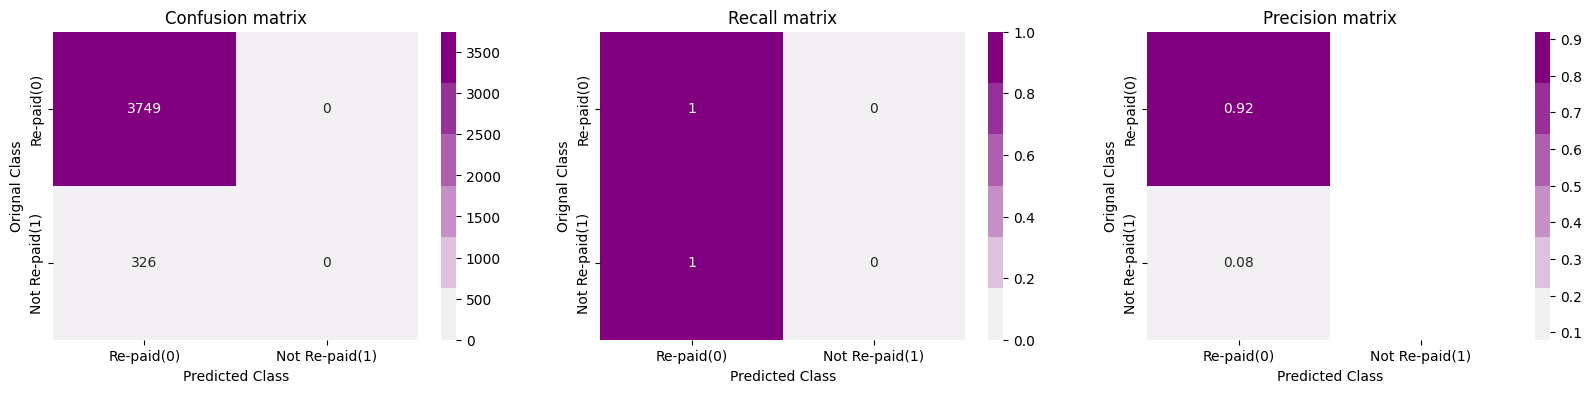

In [ ]:
best_alpha = np.argmax(cv_auc_score)
print('The optimal values are: n_estimators {0}, max_depth {1} '.format(alpha[int(best_alpha/2)],
                                                                        max_depth[int(best_alpha%2)]))
rf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)],
                            class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_final[selected_features], y_train)
rf_sig_clf = CalibratedClassifierCV(rf, method="sigmoid")
rf_sig_clf.fit(X_train_final[selected_features], y_train)
y_pred_prob = rf_sig_clf.predict_proba(X_train_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Train AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                    max_depth[int(best_alpha%2)],roc_auc_score(y_train,y_pred_prob)))
y_pred_prob = rf_sig_clf.predict_proba(X_val_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Validation AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                            max_depth[int(best_alpha%2)],roc_auc_score(y_val,y_pred_prob)))
y_pred_prob = rf_sig_clf.predict_proba(X_test_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Test AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                        max_depth[int(best_alpha%2)],roc_auc_score(y_test,y_pred_prob)))
y_pred = rf_sig_clf.predict(X_test_final[selected_features])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

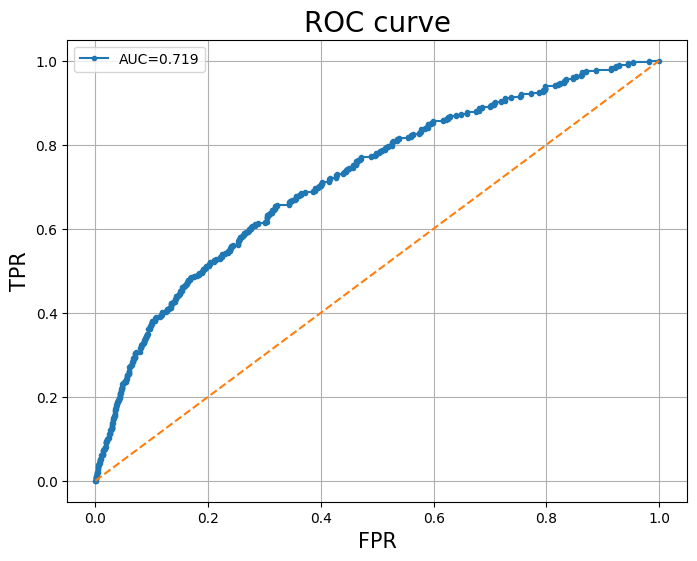

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

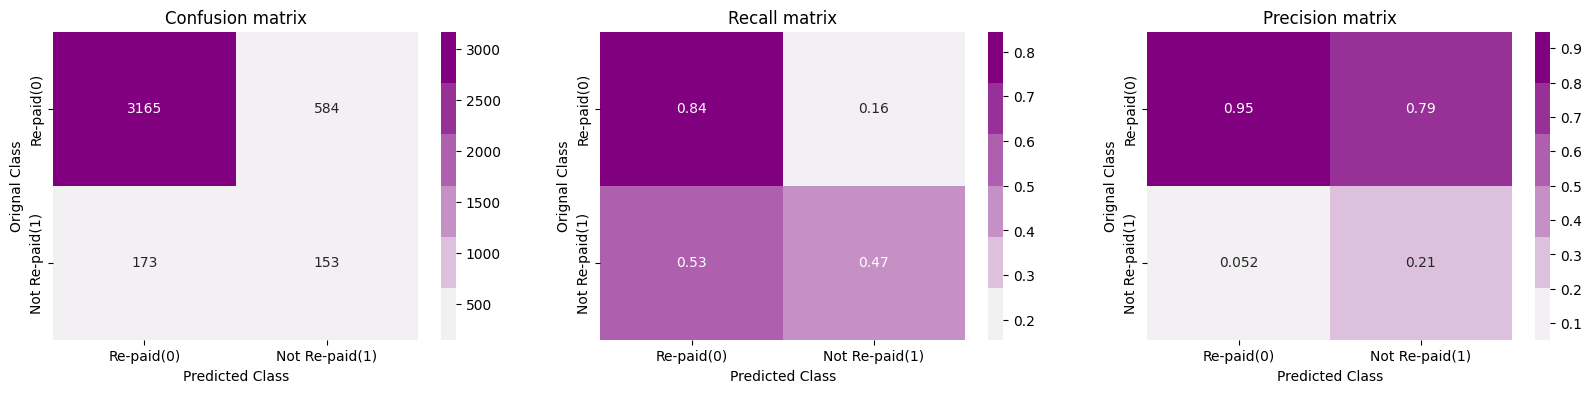

In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import re

# Exemple d'utilisation avec les variables supposées définies:
# X_train_final, X_val_final, X_test_final, y_train, y_val, y_test, selected_features

# Initialisation des poids
weight = np.ones((len(X_train_final),), dtype=int)
for i in range(len(X_train_final)):
    if y_train[i] == 0:
        weight[i] = 1
    else:
        weight[i] = 11

# Création des datasets LightGBM
train_data = lgb.Dataset(X_train_final[selected_features], label=y_train, weight=weight)
valid_data = lgb.Dataset(X_val_final[selected_features], label=y_val)

# Cross-validation pour trouver le meilleur max_depth
cv_auc_score = []
max_depth = [3, 5, 7, 10]

for i in max_depth:
    params = {
        'boosting_type': 'gbdt',
        'max_depth': i,
        'objective': 'binary',
        'nthread': 5,
        'num_leaves': 32,
        'learning_rate': 0.05,
        'max_bin': 512,
        'subsample_for_bin': 200,
        'subsample': 0.7,
        'subsample_freq': 1,
        'colsample_bytree': 0.8,
        'reg_alpha': 20,
        'reg_lambda': 20,
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight': 1,
        'num_class': 1,
        'metric': 'auc'
    }
    lgbm = lgb.train(
        params,
        train_data,
        2500,
        valid_sets=valid_data,
    )
    y_pred_prob = lgbm.predict(X_val_final[selected_features])
    cv_auc_score.append(roc_auc_score(y_val, y_pred_prob))
    print(f'For max_depth {i} and some other parameters, cross-validation AUC score {roc_auc_score(y_val, y_pred_prob)}')

# Sélection du meilleur max_depth
optimal_max_depth = max_depth[np.argmax(cv_auc_score)]
print(f'The optimal max_depth: {optimal_max_depth}')

# Entraînement final avec le meilleur max_depth
params['max_depth'] = optimal_max_depth

lgbm = lgb.train(
    params,
    train_data,
    2500,
    valid_sets=valid_data,
)

# Évaluation sur l'ensemble d'entraînement
y_pred_prob = lgbm.predict(X_train_final[selected_features])
print(f'For best max_depth {optimal_max_depth}, The Train AUC score is {roc_auc_score(y_train, y_pred_prob)}')

# Évaluation sur l'ensemble de validation
y_pred_prob = lgbm.predict(X_val_final[selected_features])
print(f'For best max_depth {optimal_max_depth}, The Cross validated AUC score is {roc_auc_score(y_val, y_pred_prob)}')

# Évaluation sur l'ensemble de test
y_pred_prob = lgbm.predict(X_test_final[selected_features])
print(f'For best max_depth {optimal_max_depth}, The Test AUC score is {roc_auc_score(y_test, y_pred_prob)}')

# Conversion des probabilités en prédictions binaires
y_pred = np.where(y_pred_prob <= 0.5, 0, 1)

print('The test AUC score is:', roc_auc_score(y_test, y_pred_prob))
print(f'The percentage of misclassified points: {(1 - accuracy_score(y_test, y_pred)) * 100:.2f}%')

# Affichage de la matrice de confusion (supposant que plot_confusion_matrix est défini)
plot_confusion_matrix(y_test, y_pred)


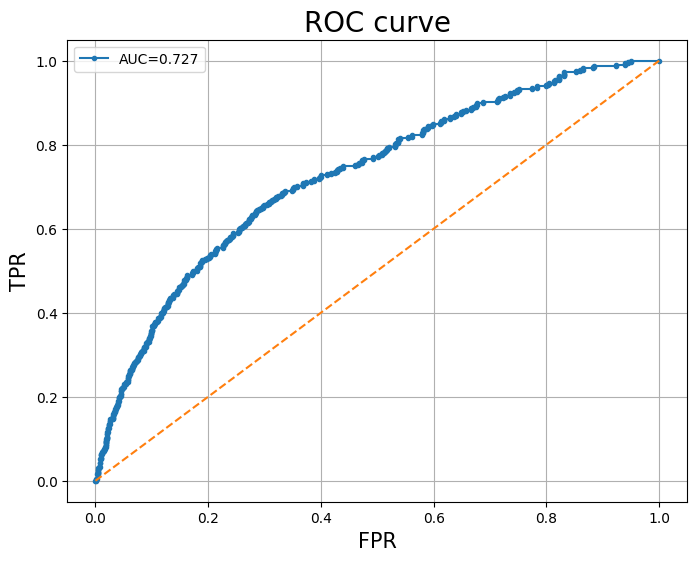

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [ ]:
with open('./lightgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm, file)

print("Le modèle a été enregistré avec succès.")

Le modèle a été enregistré avec succès.


In [ ]:
X_test_final[selected_features].to_csv('./data.csv', index=False)